In [1]:
import matplotlib
rc_fonts = {
    "font.size": 14,
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3dexp.db

from utils import get_by_expnames, get_by_ext, pretty

In [21]:
# dataset = 'jpeg/flickr50k'
num_workers=8
hostname='cloudlet027'

df_all = pd.read_sql(
    'SELECT expname, basedir, avg_wall_ms, (1 / avg_wall_ms * 1000) as throughput, num_workers, avg_mbyteps as bandwidth, avg_cpu_ms FROM EurekaExp \
        WHERE expname LIKE %s AND hostname=%s AND num_workers=%s ORDER BY expname',
    s3dexp.db.engine,
    params=["macro-%", hostname, num_workers])

df_all

,expname,basedir,avg_wall_ms,throughput,num_workers,bandwidth,avg_cpu_ms
0,macro-obama-hdd,/mnt/hdd/fast20/jpeg/flickr50k,68.350879,14.630390,8,1.102007,542.236143
1,macro-obama-smart,/mnt/hdd/fast20/jpeg/flickr50k,33.614442,29.749118,8,0.627098,11.188473
2,macro-obama-ssd,/mnt/ssd/fast20/jpeg/flickr50k,68.036684,14.697953,8,1.107096,540.884425
3,macro-pedestrian-hdd,/mnt/hdd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,3.218230,310.729780,8,10.780236,8.430496
4,macro-pedestrian-smart,/mnt/hdd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,2.894923,345.432287,8,95.525618,1.778842
5,macro-pedestrian-ssd,/mnt/ssd/fast20/video/VIRAT/mp4/VIRAT_S_000200...,3.194209,313.066548,8,10.861306,8.381142
6,macro-redbus-hdd,/mnt/hdd/fast20/jpeg/flickr50k,3.796579,263.395050,8,19.839735,6.529144
7,macro-redbus-smart,/mnt/hdd/fast20/jpeg/flickr50k,1.935770,516.590200,8,541.233539,3.987575
8,macro-redbus-ssd,/mnt/ssd/fast20/jpeg/flickr50k,2.047190,488.474443,8,36.793416,7.108906


## HDD vs SSD vs Ours

In [22]:
workloads = ['redbus', 'obama', 'pedestrian']

devices = ['hdd', 'ssd', 'smart']
device_names = ['HDD', 'SSD', 'Active Disk']
colors = ['tab:gray', 'tab:green', 'tab:red']

In [99]:
%matplotlib notebook

def plot_macro(col = 'throughput', ylabel = 'Images / s', savefig_path = 'macro-throughput.pdf', ymax=None):
    plt.figure(figsize=(6,3))

    ind = np.arange(len(workloads))
    width = 0.25       

    for i, (dev, dev_name, c) in enumerate(zip(devices, device_names, colors)):
        df = get_by_expnames(df_all, ['macro-{}-{}'.format(w, dev) for w in workloads])

        x, y = ind + i*width, df[col]
        plt.bar(x, y, width, label=dev_name, color=c)
        
        # clip y in case y > ymax
        if ymax:
            y = np.minimum(y, ymax)
        
        if col == 'throughput' and dev != 'hdd':
            # annotate speed-up
            df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
            for x1, y1, s1 in zip(x, y, y / df_hdd['throughput']):
                plt.annotate('{:.1f}x'.format(s1), (x1 - width*.4, y1 + 30))
                
        if col == 'avg_cpu_ms' and dev != 'hdd':
            # annotate saving of CPU time
            print "annotating CPU time saving"
            df_hdd = get_by_expnames(df_all, ['macro-{}-{}'.format(w, 'hdd') for w in workloads])
            for x1, y1, s1 in zip(x, y, y / df_hdd['avg_cpu_ms']):
                print x1, y1, s1
                plt.annotate('{:4.0f}\%'.format(s1*100), (x1 - width*.4, y1 + 1))
            


    plt.ylabel(ylabel)
    plt.ylim(None, ymax)
    plt.xticks(ind + width, map(pretty, workloads))
    plt.legend(bbox_to_anchor=(.5, 1), loc='lower center', ncol=len(ind))
    # plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig(savefig_path, bbox_inches ='tight')

    plt.show()

<IPython.core.display.Javascript object>


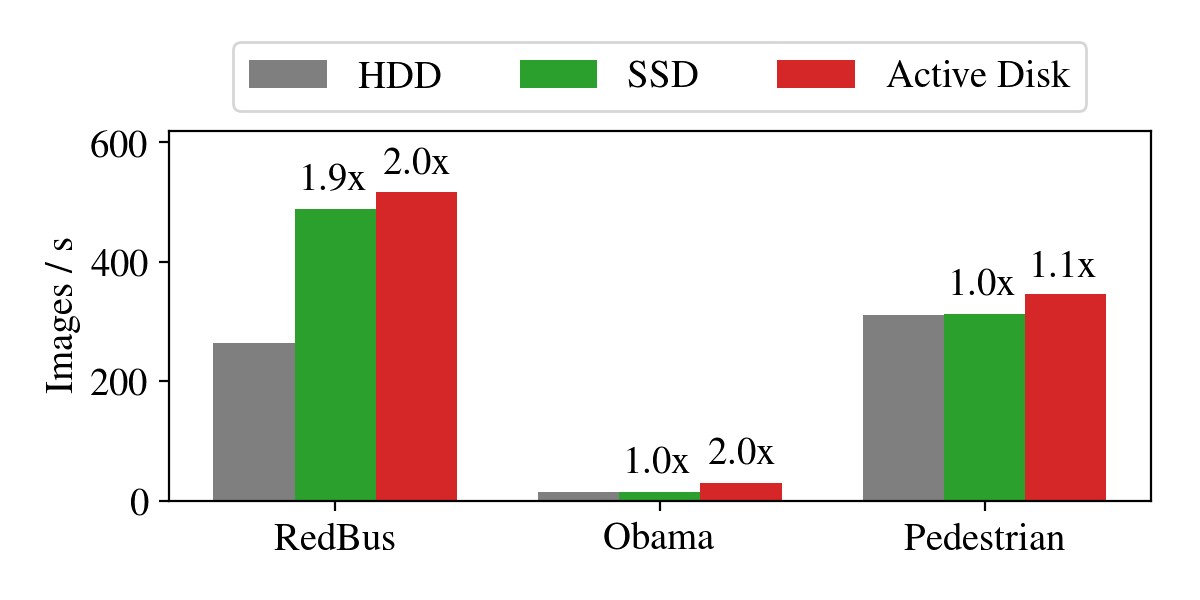

<IPython.core.display.Javascript object>


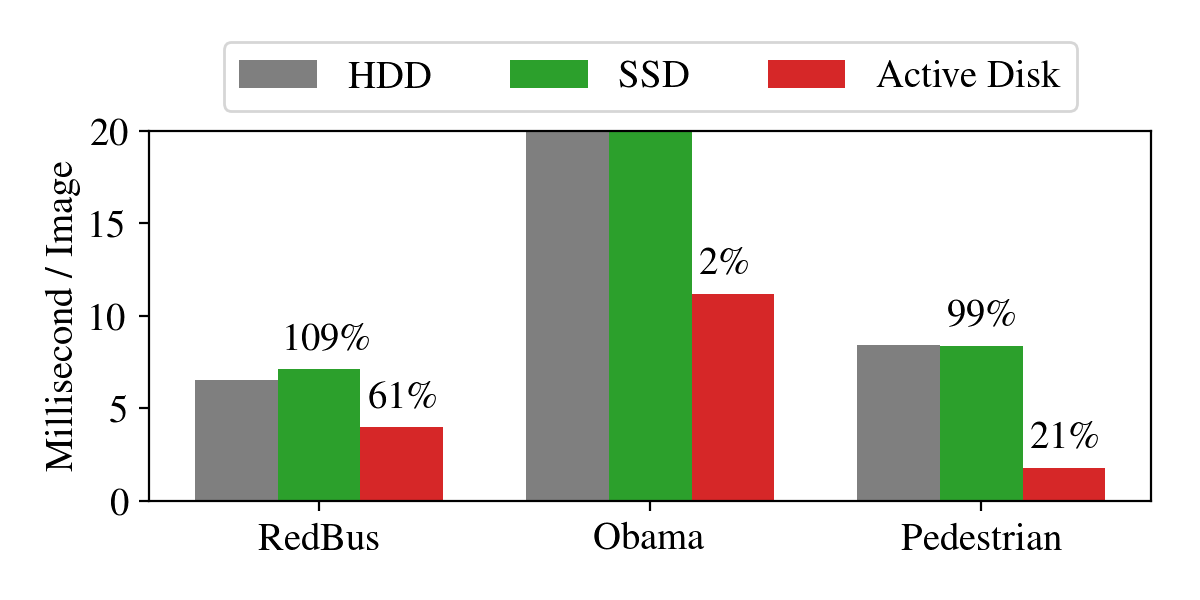

annotating CPU time saving
0.25 7.10890627901 1.08879611715
1.25 20.0 0.036884298981
2.25 8.38114209058 0.994145835348
annotating CPU time saving
0.5 3.98757524344 0.610734798221
1.5 11.188473049 0.0206339492541
2.5 1.77884181155 0.211000858783


In [100]:
plot_macro('throughput', 'Images / s', savefig_path='macro-throughput.pdf', ymax=620)
# plot_macro('bandwidth', 'MByte / s', savefig_path= 'macro-bandwidth.pdf')
plot_macro('avg_cpu_ms', 'Millisecond / Image', savefig_path = 'macro-cputime.pdf', ymax=20)